In [65]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import pandas as pd
import datetime
import scipy.optimize as sco

Random Sampling

In [66]:
available_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META", "BRK-B", "JNJ", "XOM", 
    "V", "UNH", "JPM", "WMT", "PG", "MA", "HD", "CVX", "KO", "PEP"
]

total_number=7
sample=random.sample(available_tickers,total_number)
print(f"Randomly Selected Portfolio: {sample}")

Randomly Selected Portfolio: ['JNJ', 'AMZN', 'NVDA', 'MSFT', 'MA', 'HD', 'CVX']


Collecting The Close Prices

In [67]:
def fetch_closing_price(names,start_date="2021-01-01", end_date=datetime.date.today()):
    data=yf.download(names,start_date,end_date)["Adj Close"]
    return data
    
closing_prices=fetch_closing_price(sample)
print(f"The Closing Prices: {closing_prices}")

[*********************100%%**********************]  7 of 7 completed

The Closing Prices: Ticker            AMZN         CVX          HD         JNJ          MA  \
Date                                                                     
2021-01-04  159.331497   71.667786  239.481903  139.933884  343.134460   
2021-01-05  160.925507   73.605202  241.414688  141.579117  339.161163   
2021-01-06  156.919006   75.974106  242.794006  142.911423  339.288147   
2021-01-07  158.108002   76.329437  241.605255  143.394241  341.976166   
2021-01-08  159.134995   77.057022  244.173203  143.099182  345.876282   
...                ...         ...         ...         ...         ...   
2025-01-10  218.940002  153.139999  389.890015  142.059998  504.670013   
2025-01-13  218.460007  155.350006  389.179993  144.470001  504.910004   
2025-01-14  217.759995  156.899994  392.779999  144.750000  509.019989   
2025-01-15  223.350006  158.330002  406.089996  144.970001  522.349976   
2025-01-16  220.660004  159.380005  409.329987  147.770004  523.140015   

Ticker           

Training Data

In [68]:
train_data=closing_prices[:-252]
train_data

Ticker,AMZN,CVX,HD,JNJ,MA,MSFT,NVDA
Date,,,,,,,
2021-01-04,159.331497,71.667786,239.481903,139.933884,343.134460,210.423096,13.080302
2021-01-05,160.925507,73.605202,241.414688,141.579117,339.161163,210.626053,13.370815
2021-01-06,156.919006,75.974106,242.794006,142.911423,339.288147,205.164703,12.582567
2021-01-07,158.108002,76.329437,241.605255,143.394241,341.976166,211.003021,13.310218
2021-01-08,159.134995,77.057022,244.173203,143.099182,345.876282,212.288666,13.243139
...,...,...,...,...,...,...,...
2024-01-09,151.369995,139.682327,337.913330,156.669983,420.212433,373.000732,53.124939
2024-01-10,153.729996,138.531891,348.269653,156.902618,425.850372,379.928925,54.334591
2024-01-11,155.179993,139.279663,348.006073,156.204712,424.309143,381.775116,54.806461


<Axes: xlabel='Ticker', ylabel='Ticker'>

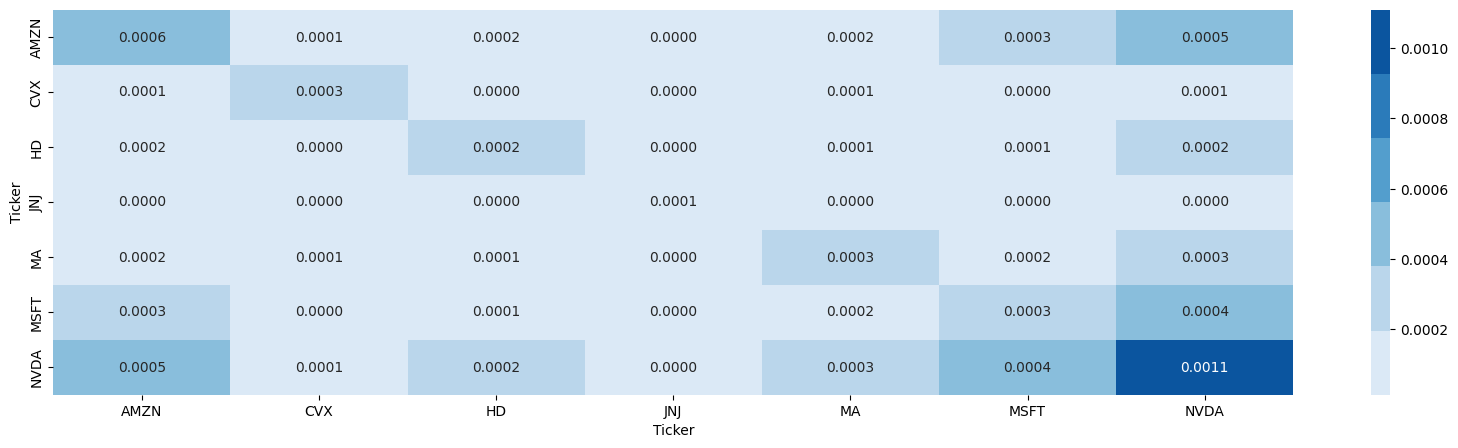

In [215]:
daily_percentage_changes=train_data.pct_change()[1:]
daily_percentage_change_mean=daily_percentage_changes.mean()


daily_cov_matrix=daily_percentage_changes.cov()
plt.figure(figsize=(20,5))
heatmap=sns.heatmap(daily_cov_matrix,annot=True,fmt=".4f",cmap=sns.color_palette("Blues"))
heatmap

/var/folders/8n/8xk8_xtj41s1c_d4wky2m19m0000gn/T/ipykernel_10787/420693945.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df=train_data.resample("M").last()


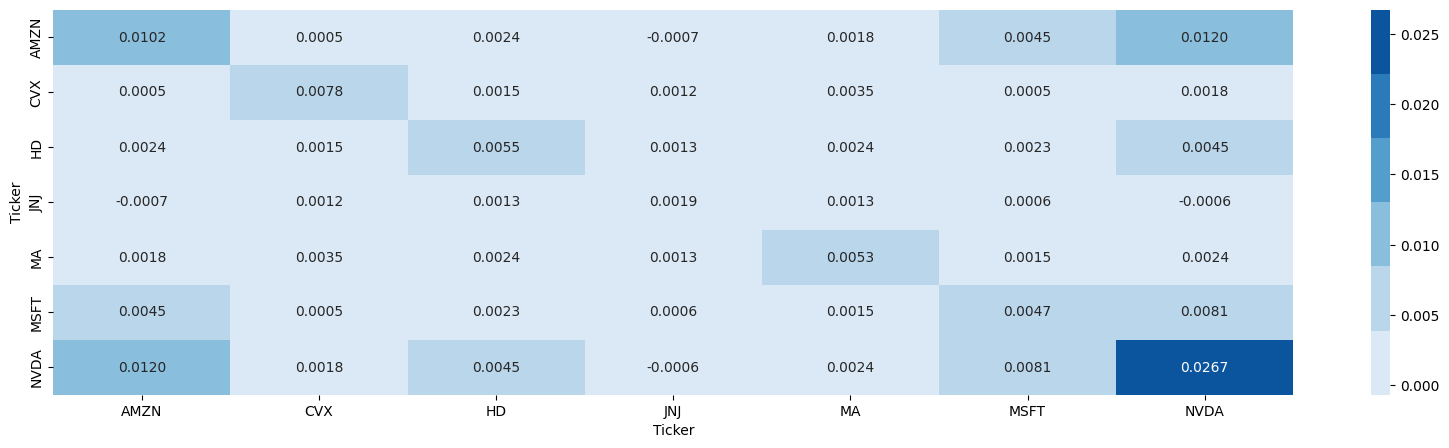

In [214]:
monthly_df=train_data.resample("M").last()
monthly_df

monthly_percentage_change=monthly_df.pct_change()
monthly_percentage_change_mean=monthly_percentage_change.mean()

monthly_cov_matrix=monthly_percentage_change.cov()
plt.figure(figsize=(20,5))
heatmap=sns.heatmap(monthly_cov_matrix,annot=True,fmt=".4f",cmap=sns.color_palette("Blues"))

Monte Carlo Simulation

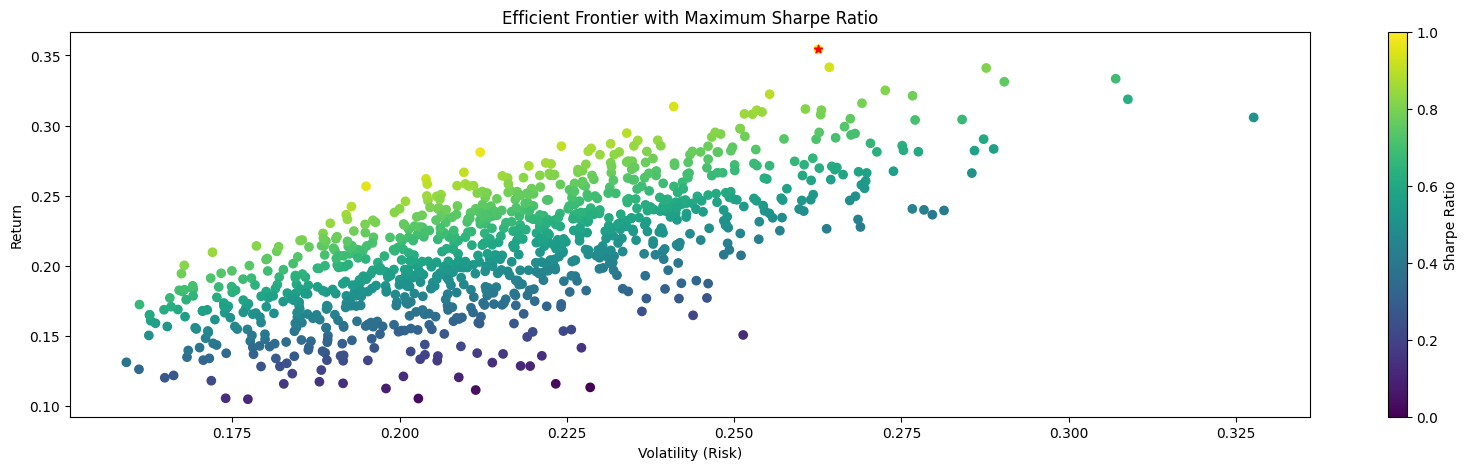

In [213]:
number_of_portfolios=1000
portfolio_infos=np.zeros((3,number_of_portfolios))
risk_free_rate=0
for i in range(number_of_portfolios):
    weights=np.random.random(len(sample))
    weights/=np.sum(weights)
    
    portfolio_return=np.sum(weights*daily_percentage_change_mean)*252 #trading days and annualizing
    portfolio_volatility=np.sqrt(np.dot(weights.T,np.dot(daily_cov_matrix,weights)))*np.sqrt(252)
    sharpe_ratio=(portfolio_return-risk_free_rate)/portfolio_volatility

    portfolio_infos[0,i]=portfolio_return
    portfolio_infos[1,i]=portfolio_volatility
    portfolio_infos[2,i]=sharpe_ratio

max_sharpe_idx=portfolio_infos[2].argmax()
max_sharpe_return=portfolio_infos[0,max_sharpe_idx]
max_sharpe_volatility=portfolio_infos[1,max_sharpe_idx]

plt.figure(figsize=(20,5))
plt.scatter(portfolio_infos[1,:],portfolio_infos[0,:],c=portfolio_infos[2,:],cmap="viridis",marker="o")
plt.scatter(max_sharpe_volatility,max_sharpe_return,color="red",marker="*")
plt.title('Efficient Frontier with Maximum Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()
    


Optimization

In [72]:
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return=np.sum(weights*mean_returns)*252 #trading days and annualizing
    portfolio_volatility=np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))*np.sqrt(252)
    sharpe_ratio=(portfolio_return-risk_free_rate)/portfolio_volatility
    return -sharpe_ratio

bounds=[[0,1] for _ in range(len(sample))]
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

n_times=100
best_sharpe=-np.Inf
best_x=0
for i in range(n_times):
    initial_guess=np.random.random(len(sample))
    result=sco.minimize(negative_sharpe, initial_guess,args=(daily_percentage_change_mean,daily_cov_matrix,risk_free_rate),bounds=bounds,constraints=constraints)
    if -result.fun>best_sharpe:
        best_x=result.x
        best_sharpe=-result.fun


In [105]:
print(best_x,best_sharpe)

[0.00000000e+00 4.89421201e-01 3.03151516e-02 1.19923759e-01
 1.29184752e-16 1.87205336e-02 3.41619355e-01] 1.4121509394348075


Portfolio 

In [148]:
portfolio=pd.DataFrame(columns=closing_prices.columns,data=best_x.reshape(1,-1))
portfolio

Ticker,AMZN,CVX,HD,JNJ,MA,MSFT,NVDA
0,0.0,0.489421,0.030315,0.119924,1.291848e-16,0.018721,0.341619


In [151]:
threshold=0.03
other_weight=portfolio[portfolio<threshold].sum(axis=1)
columns_to_drop = portfolio.columns[(portfolio < threshold).all()]
portfolio.drop(columns=columns_to_drop, inplace=True)
portfolio["Others"]=other_weight
portfolio

Ticker,CVX,HD,JNJ,NVDA,Others
0,0.489421,0.030315,0.119924,0.341619,0.018721


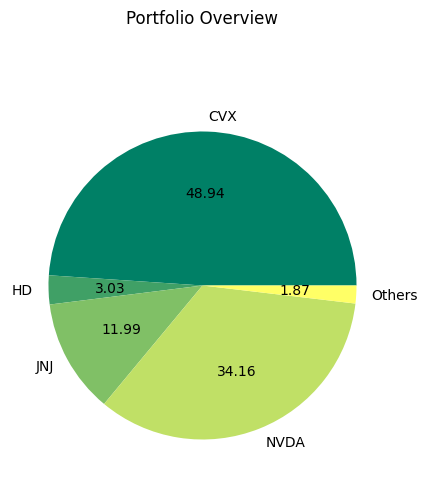

In [218]:
colors = plt.cm.summer(np.linspace(0, 1, len(portfolio.columns)))
plt.figure(figsize=(20,5))
plt.title("Portfolio Overview",fontdict={"fontsize":12},pad=50)
plt.pie(x=portfolio.values.flatten(),labels=portfolio.columns,autopct="%.2f",colors=colors,textprops={"fontsize":"10"}) #We hav flattened because the function expects a 1D array
plt.show()


Backtesting

In [74]:
test_data=closing_prices[-252:]
test_data

Ticker,AMZN,CVX,HD,JNJ,MA,MSFT,NVDA
Date,,,,,,,
2024-01-17,151.710007,137.208878,347.195923,155.506805,425.005219,386.579224,56.037113
2024-01-18,153.500000,135.962585,349.343292,156.262863,428.286560,390.946503,57.090813
2024-01-19,155.339996,136.365234,353.745514,156.718445,434.312317,395.710907,59.474140
2024-01-22,154.779999,136.604919,348.162262,157.484207,437.265533,393.566956,59.637096
2024-01-23,156.020004,136.221420,342.393524,154.905823,436.281158,395.939178,59.856033
...,...,...,...,...,...,...,...
2025-01-10,218.940002,153.139999,389.890015,142.059998,504.670013,418.950012,135.910004
2025-01-13,218.460007,155.350006,389.179993,144.470001,504.910004,417.190002,133.229996
2025-01-14,217.759995,156.899994,392.779999,144.750000,509.019989,415.670013,131.759995


In [75]:
test_data_percentage_change=test_data.pct_change().dropna()
portfolio_returns=(best_x*test_data_percentage_change).sum(axis=1)
cumulative_portfolio_returns=(1+portfolio_returns).cumprod()-1
cumulative_portfolio_returns

Date
2024-01-18    0.002960
2024-01-19    0.019680
2024-01-22    0.021518
2024-01-23    0.018992
2024-01-24    0.036798
                ...   
2025-01-10    0.474358
2025-01-13    0.477641
2025-01-14    0.479944
2025-01-15    0.506235
2025-01-16    0.504779
Length: 251, dtype: float64

In [76]:
benchmark_data_full=yf.download("^GSPC",start="2021-01-01",end=datetime.date.today())["Adj Close"]
benchmark_data=benchmark_data_full[-252:]
benchmark_data_percentage_change=benchmark_data.pct_change().dropna()
benchmark_data_returns=(1+benchmark_data_percentage_change).cumprod()-1
benchmark_data_returns


[*********************100%%**********************]  1 of 1 completed


Date
2024-01-18    0.008805
2024-01-19    0.021227
2024-01-22    0.023468
2024-01-23    0.026458
2024-01-24    0.027291
                ...   
2025-01-10    0.229538
2025-01-13    0.231475
2025-01-14    0.232887
2025-01-15    0.255465
2025-01-16    0.252812
Name: Adj Close, Length: 251, dtype: float64

In [77]:
benchmark_sharpe=benchmark_data_percentage_change.mean()/benchmark_data_percentage_change.std()*np.sqrt(252)
portfolio_sharpe=portfolio_returns.mean()/portfolio_returns.std()*np.sqrt(252)
print(f"Benchmark Sharpe: {benchmark_sharpe}\nPortfolio Sharpe: {portfolio_sharpe}")


Benchmark Sharpe: 1.823996624921973
Portfolio Sharpe: 2.1109406088537312


Text(0, 0.5, 'Cumulative Return')

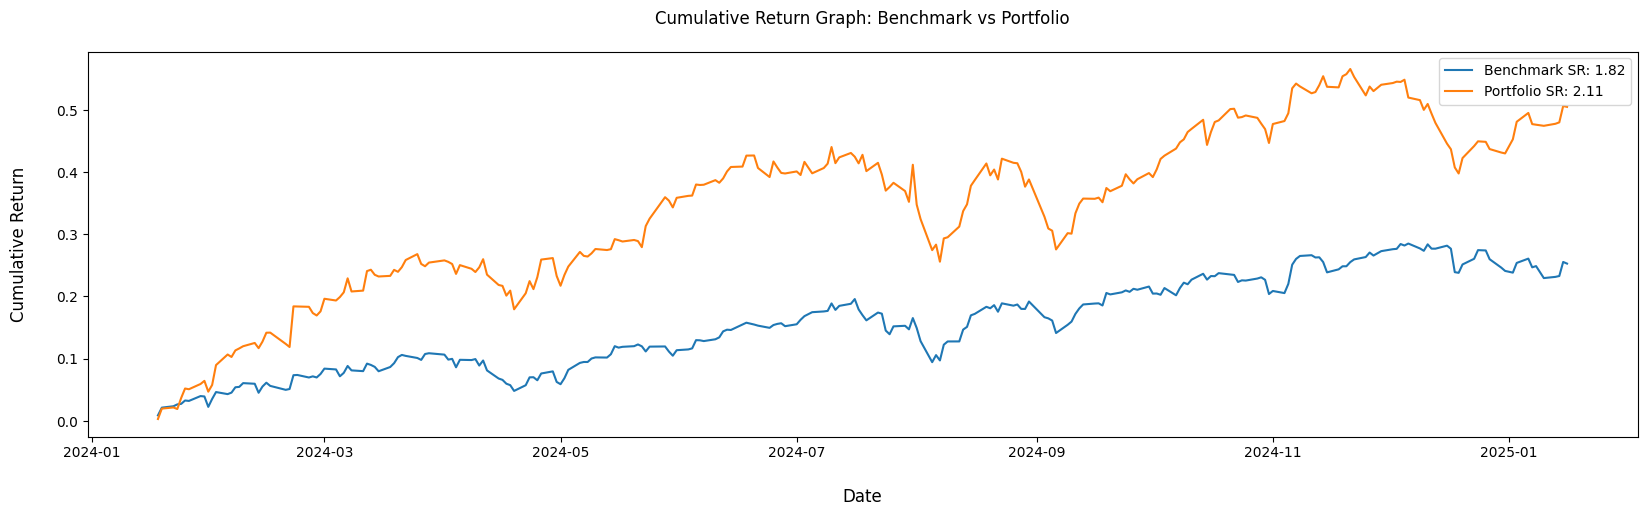

In [216]:
plt.figure(figsize=(20,5))
plt.plot(benchmark_data_returns.index,benchmark_data_returns,label=f"Benchmark SR: {benchmark_sharpe:.2f}")
plt.plot(cumulative_portfolio_returns.index,cumulative_portfolio_returns,label=f"Portfolio SR: {portfolio_sharpe:.2f}")
plt.title("Cumulative Return Graph: Benchmark vs Portfolio",pad=20)
plt.legend()
plt.xlabel("Date",labelpad=20,fontdict={"fontsize":12})
plt.ylabel("Cumulative Return",labelpad=20,fontdict={"fontsize":12})